In [ ]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,ZeroPadding2D, BatchNormalization, Activation, Layer, ReLU, LeakyReLU,Conv2D,AveragePooling2D,UpSampling2D,Reshape,Flatten
from tensorflow.keras import backend as K

In [ ]:
# Must be TF version 2
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Penn/Colab/Data/')

In [ ]:
from func import load_model, save_model

In [109]:
input_shape = 57
latent_dimension = 3
num_nodes=[16,8]

#encoder
inputArray = Input(shape=(input_shape))
x = Dense(num_nodes[0], use_bias=False)(inputArray)
x = Activation('relu')(x)
x = Dense(latent_dimension, use_bias=False)(x)
encoder = Activation('relu')(x)

#decoder
x = Dense(num_nodes[0], use_bias=False)(encoder)
x = Activation('relu')(x)
decoder = Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense_9 (Dense)             (None, 16)                912       
                                                                 
 activation_10 (Activation)  (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 48        
                                                                 
 activation_11 (Activation)  (None, 3)                 0         
                                                                 
 dense_11 (Dense)            (None, 16)                48        
                                                                 
 activation_12 (Activation)  (None, 16)                0   

## Load dataset

In [ ]:
# You should already have run
# python create_datasets.py --bkg_file /ocean/projects/cis210053p/jngadiub/background_for_training.h5 --output_bkg_name 'BKG' --signals_files '/ocean/projects/cis210053p/jngadiub/Ato4l_lepFilter_13TeV.h5' --output_signal_names 'Ato4l_lepFilter_13TeV' --events=1000000
filename = 'BKG_dataset.h5'

In [ ]:
# load background training data
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/BKG_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)
X_train = np.reshape(X_train, (-1, 19,3,1))
X_test = np.reshape(X_test, (-1, 19,3,1))
X_val = np.reshape(X_val, (-1, 19,3,1))

print(X_train.shape)

(640000, 57)
(640000, 19, 3, 1)


## Define CNN architecture

In [ ]:
image_shape = (19,3,1)
latent_dimension = 8
num_nodes=[16,8]

In [ ]:
#encoder
input_encoder = Input(shape=(image_shape))
x = Conv2D(10, kernel_size=(3, 3),
         use_bias=False, data_format='channels_last', padding='same')(input_encoder)
x = AveragePooling2D(pool_size = (2, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(latent_dimension)(x)
enc = Activation('relu')(x)
encoder = Model(inputs=input_encoder, outputs=enc)
#decoder
x = Dense(270)(enc)
x = Activation('relu')(x)
x = Reshape((9,3,10))(x)
x = UpSampling2D((2, 1))(x)
x = ZeroPadding2D(((1, 0),(0,0)))(x)
x = Conv2D(1, kernel_size=(3,3), use_bias=False, data_format='channels_last', padding='same')(x)
x = BatchNormalization()(x)
dec = Activation('relu')(x)

autoencoder = Model(inputs=input_encoder, outputs=dec)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 3, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 19, 3, 10)         90        
                                                                 
 average_pooling2d (AverageP  (None, 9, 3, 10)         0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 9, 3, 10)         40        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 9, 3, 10)          0         
                                                                 
 flatten (Flatten)           (None, 270)               0   

In [ ]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Train model

In [ ]:
EPOCHS = 10
BATCH_SIZE = 1024

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
625/625 [==============================] - 60s 92ms/step - loss: 64.6700 - val_loss: 55.4924
Epoch 2/10
625/625 [==============================] - 58s 93ms/step - loss: 52.7153 - val_loss: 47.0563
Epoch 3/10
625/625 [==============================] - 55s 89ms/step - loss: 43.8549 - val_loss: 37.9959
Epoch 4/10
625/625 [==============================] - 53s 85ms/step - loss: 36.4483 - val_loss: 31.3566
Epoch 5/10
625/625 [==============================] - 58s 93ms/step - loss: 30.0388 - val_loss: 25.7801
Epoch 6/10
625/625 [==============================] - 65s 103ms/step - loss: 24.4328 - val_loss: 20.8855
Epoch 7/10
625/625 [==============================] - 71s 113ms/step - loss: 19.5466 - val_loss: 16.4329
Epoch 8/10
625/625 [==============================] - 69s 111ms/step - loss: 15.3084 - val_loss: 12.5093
Epoch 9/10
625/625 [==============================] - 63s 101ms/step - loss: 11.7054 - val_loss: 9.4285
Epoch 10/10
625/625 [==============================] - 55s 88

In [ ]:
model_name = 'CNN_AE'
autoencoder.save('/content/gdrive/MyDrive/Penn/Colab/Data/'+model_name+'.keras')

In [ ]:
loaded_model = keras.saving.load_model('/content/gdrive/MyDrive/Penn/Colab/Data/'+model_name+'.keras')

In [ ]:
# model_name = 'CNN_AE2'
# model_directory = '/content/gdrive/MyDrive/Penn/Colab/Data/'
# save_model(model_directory+model_name, autoencoder)

## Prediction - background

In [ ]:
bkg_prediction = loaded_model.predict(X_test)

6250/6250 [==============================] - 19s 3ms/step


## Prediction - Signals

In [ ]:
# add correct signal labels
signal_labels = ['Ato4l']

In [ ]:
# add correct path to signal files
signals_file = ['/content/gdrive/MyDrive/Penn/Colab/Data/Ato4l_lepFilter_13TeV_dataset.h5']

In [ ]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)

#signal_data = signal_data[0]
signal_data = np.reshape(signal_data, (1, -1, 19,3,1))

In [ ]:
print(np.array(signal_data).shape)

(1, 55969, 19, 3, 1)


In [ ]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i])
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

1750/1750 [==============================] - 6s 3ms/step


## Save results

In [ ]:
save_file = 'cnnvae_results'

In [ ]:
with h5py.File('/content/gdrive/MyDrive/Penn/Colab/Data/'+save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

## Evaluate results

1. Plot loss distribution after prediction (check loss value for signals)
2. Plot ROC curves - how good is anomaly detection for chosen FPR threshold

# 1.

In [ ]:
from func import mse_loss

In [ ]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2])),\
                           (bkg_prediction.reshape((bkg_prediction.shape[0],bkg_prediction.shape[1]*bkg_prediction.shape[2]))).astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X.reshape((signal_X.shape[0],signal_X.shape[1]*signal_X.shape[2])),\
                               (signal_results[i][2].reshape((signal_X.shape[0],signal_X.shape[1]*signal_X.shape[2]))).astype(np.float32)).numpy())

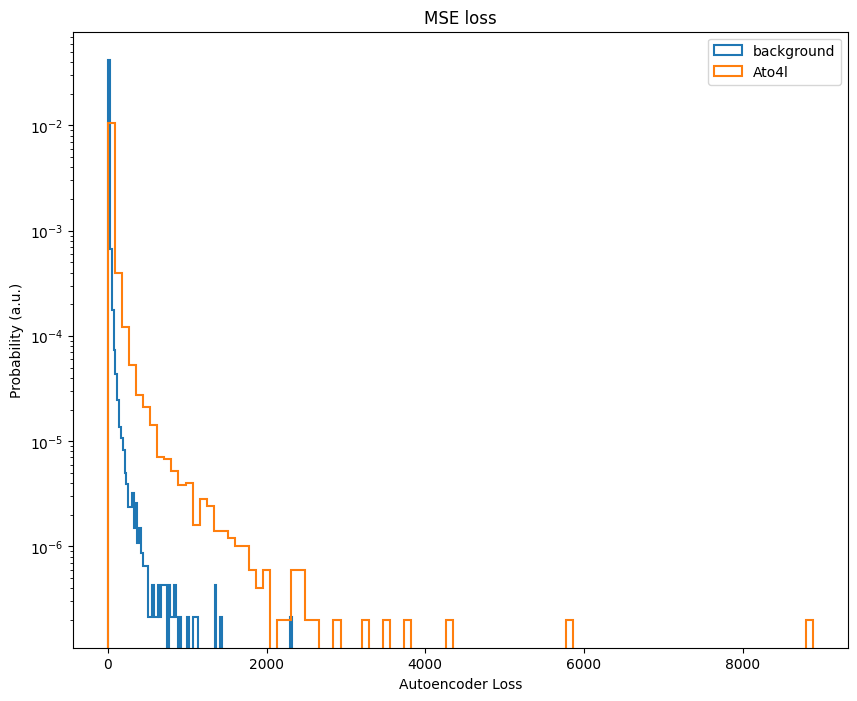

In [ ]:
bin_size=100

plt.figure(figsize=(10,8))
# for i, label in enumerate(signal_labels):
#     plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

plt.hist(total_loss[0], bins=bin_size, label='background', density = True, histtype='step', fill=False, linewidth=1.5)
plt.hist(total_loss[1], bins=bin_size, label='Ato4l', density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

# 2.

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

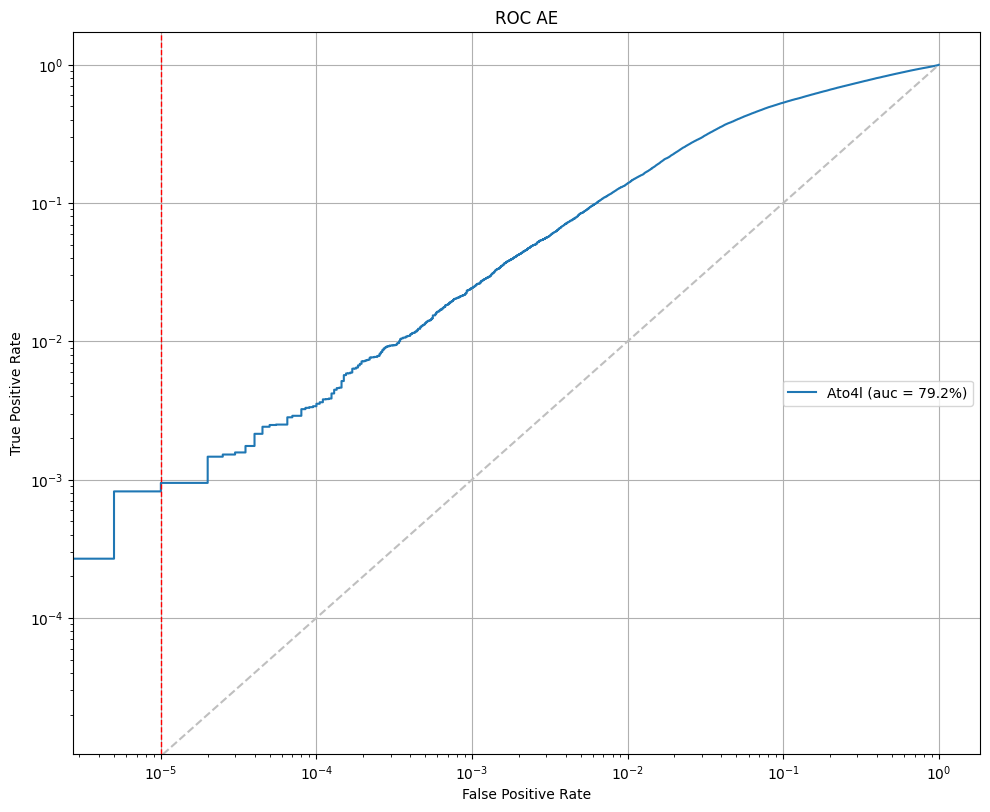

In [ ]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events

    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()